In [26]:
%load_ext blackcellmagic
%load_ext autoreload
%autoreload 2

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# TODO: Add this as an script 
# TODO: Add heatmap for diff of median and std

In [28]:
from mic_analysis.variables import all_variables_names_enhanced
from confapp import conf
import pandas as pd
from mic_analysis.datasets import data_filter
from natsort import natsorted
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.size"] = "14"

In [29]:
pairs_to_plot = {
    "indiv": ("HET_HET-HET", "DEL_DEL-DEL"),
    "group": ("HET_HET", "DEL_DEL"), 
    "indiv_nb": ("HET-DEL", "DEL-HET")
}
default_replicate_treatment = '_standardized'

# TODO: Make this mapping of variables general for all scripts
mapping_variables_names = {
    "mean_distance_to_center_of_group_standardized": "group dispersion",
    "nb_angle": "followership",
    "nb_distance_standardized": "interindividual distance",
    "normal_acceleration_standardized": "turning accel",
    "normed_distance_to_origin_standardized": "distance to center",
    "polarization_order_parameter_standardized": "polarization", 
    "rotation_order_parameter_standardized": "rotation", 
    "speed_standardized": "speed"
} 

In [30]:
DATE = '20220727'
STAT = 'std'

In [31]:
videos_table = pd.read_csv(conf.VIDEOS_INDEX_FILE_NAME)

In [32]:
partition_col = "line_experiment"
videos_to_plot = data_filter(videos_table, filters=conf.DATA_FILTERS['experiment_1'])

In [33]:
individual_vars = [
    ("speed_standardized", "mean"),
    ("speed_standardized", "median"),
    ("speed_standardized", "std"),
    ("normed_distance_to_origin_standardized", "mean"),
    ("normed_distance_to_origin_standardized", "median"),
    ("normed_distance_to_origin_standardized", "std"),
    ("normal_acceleration_standardized", "mean"),
    ("normal_acceleration_standardized", "median"),
    ("normal_acceleration_standardized", "std"),
]
group_vars = [
    ("mean_distance_to_center_of_group_standardized", "mean"),
    ("mean_distance_to_center_of_group_standardized", "median"),
    ("mean_distance_to_center_of_group_standardized", "std"),
    ("polarization_order_parameter_standardized", "mean"),
    ("polarization_order_parameter_standardized", "median"),
    ("polarization_order_parameter_standardized", "std"),
    ("rotation_order_parameter_standardized", "mean"),
    ("rotation_order_parameter_standardized", "median"),
    ("rotation_order_parameter_standardized", "std"),
]
indiv_nb_vars = [
    ("nb_distance_standardized", "mean"),
    ("nb_distance_standardized", "median"),
    ("nb_distance_standardized", "std"),
    ("nb_angle", "ratio_in_front"),
]

variables = individual_vars + group_vars + indiv_nb_vars
variables = [str(var_) for var_ in variables]

partitions = natsorted(videos_to_plot[partition_col].unique())
heatmap_vals = {}
heatmap_pvals = {}
for partition in partitions:
    stats_file = os.path.join(
        conf.GENERATED_FIGURES_PATH,
        f"summary_{partition_col}_{DATE}_{STAT}",
        partition,
        "all_test_stats.csv",
    )
    if os.path.isfile(stats_file):
        stats = pd.read_csv(stats_file)

        # variables = [
        #     var
        #     for var in stats.variable.unique()
        #     if default_replicate_treatment in var and "nb_angle" not in var
        # ]
        # variables += ["('nb_angle', 'ratio_in_front')"]
        # variables = natsorted(variables)

        vals = {}
        p_vals = {}
        for variable in variables:
            if variable in stats['variable'].unique():
                var_stats = stats[stats["variable"] == variable]
                var_type = var_stats["var_type"].unique()[0]
                has_WT = var_stats.group_a.str.contains("WT").sum() > 0
                pair_to_plot = pairs_to_plot[f"{var_type}"]
                variable_name = eval(variable)
                variable_name = (
                    f"{mapping_variables_names[variable_name[0]]} ({variable_name[1]})"
                )
                if "nb_distance" in variable:
                    pair_to_plot = ("HET-HET", "DEL-DEL")
                group_a = pair_to_plot[0]
                group_b = pair_to_plot[1]
                var_stats_ = var_stats[
                    (var_stats.group_a == group_a) & (var_stats.group_b == group_b)
                ]
                if len(var_stats_) == 1:
                    var_stats_ = var_stats_.iloc[0]
                    if not np.isnan(var_stats_["value"]):
                        vals[variable_name] = var_stats_["stat_b"] - var_stats_["stat_a"]
                        p_vals[variable_name] = var_stats_["p_value"]
                    else:
                        vals[variable_name] = np.nan
                        p_vals[variable_name] = 1
                else:
                    vals[variable_name] = np.nan
                    p_vals[variable_name] = 1
            else:
                print(f"{variable} not in stats")

        if vals:
            heatmap_vals[partition] = vals
            heatmap_pvals[partition] = p_vals

heatmap_vals = pd.DataFrame(heatmap_vals)
heatmap_pvals = pd.DataFrame(heatmap_pvals)

heatmap_stars = heatmap_pvals.copy()
heatmap_stars[heatmap_pvals >= 0.05] = ""
heatmap_stars[heatmap_pvals < 0.05] = "*"

heatmap_pvals[heatmap_vals.isna()] = np.nan
heatmap_stars[heatmap_vals.isna()] = np.nan

heatmap_vals.dropna(axis=1, inplace=True)
heatmap_pvals.dropna(axis=1, inplace=True)
heatmap_stars.dropna(axis=1, inplace=True)

('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') not in stats
('nb_angle', 'ratio_in_front') n

In [34]:
heatmap_vals

,ap1g1_1_1,apbb1_1_1,asap1b_7_1,cdon_1_1,evi5b_6_1,gli2b_1_1,gli3_7_1,itsn1_1_1,itsn1_3_1,kif1b_1_1,...,mef2ca_2_1,reln_2_1,shank3a_2_1,shank3b_1_1,src_1_1,srrm3_17_1,srrm4_12_1,vav2_1_1,vdac3_5_1,vti1a_1_1
speed (mean),0.165511,0.140294,-0.003886,-0.065736,0.378461,0.066870,0.012176,0.033195,-0.013442,-0.041255,...,-0.023665,-0.238490,-0.032068,0.114569,0.236064,-0.090362,-0.046278,-0.041971,-0.060736,0.057592
speed (median),0.160922,0.165950,0.010075,-0.073640,0.386617,0.075459,-0.162072,0.043174,-0.019368,-0.125880,...,0.006237,-0.075324,-0.035020,-0.050055,0.208523,-0.036704,-0.055259,-0.042931,-0.077246,0.051952
speed (std),0.023630,0.001060,-0.029678,0.005297,0.122994,-0.006015,0.041864,0.048749,-0.014389,-0.105837,...,-0.065164,-0.186249,-0.006017,0.062675,0.142412,-0.021338,0.042180,0.087433,0.075837,0.051767
distance to center (mean),0.127153,-0.182944,-0.079861,-0.278833,0.002513,-0.009807,0.140300,-0.070665,-0.074152,0.175098,...,0.308101,-0.086324,0.101377,-0.174571,0.013828,0.319004,0.273816,0.025958,-0.117400,0.026990
distance to center (median),0.074782,-0.045915,0.085346,-0.264891,-0.022838,0.011849,0.074084,-0.009532,-0.230521,0.271453,...,0.294522,-0.175968,0.148320,-0.143824,-0.014226,0.475912,0.330364,-0.049204,-0.095456,0.018679
distance to center (std),0.030782,-0.102669,-0.036187,-0.085036,0.045039,0.125801,0.035790,-0.070364,0.015872,-0.011791,...,0.060039,0.040392,-0.016322,-0.154628,-0.018029,-0.058985,0.120956,0.084489,0.026658,0.045611
turning accel (mean),0.001849,-0.014191,-0.009475,-0.022511,0.053196,0.017205,-0.031403,0.001333,0.013490,-0.027777,...,0.020058,-0.029858,0.019241,-0.007882,-0.000178,-0.013160,-0.000740,0.006788,-0.001092,0.017036
turning accel (median),0.003255,-0.002470,-0.003144,-0.005093,0.019338,0.006914,0.000305,-0.001388,0.002271,0.001895,...,-0.009070,-0.006272,0.030445,-0.001403,0.004921,-0.025022,0.000034,0.000761,0.000882,0.001460
turning accel (std),0.048290,0.091684,0.002626,-0.107537,0.152445,0.016769,0.079777,-0.018406,-0.040139,-0.117626,...,0.007647,-0.038241,-0.016171,0.209064,0.227909,-0.032359,0.053794,0.036287,0.003352,-0.025767
group dispersion (mean),0.106883,-0.231902,-0.180401,0.060710,0.058387,-0.219515,-0.003515,-0.127708,0.074853,0.214076,...,0.051078,-0.231215,-0.025916,0.041953,0.015125,3.116787,-0.030643,0.309757,-0.096581,0.074994


<AxesSubplot:>

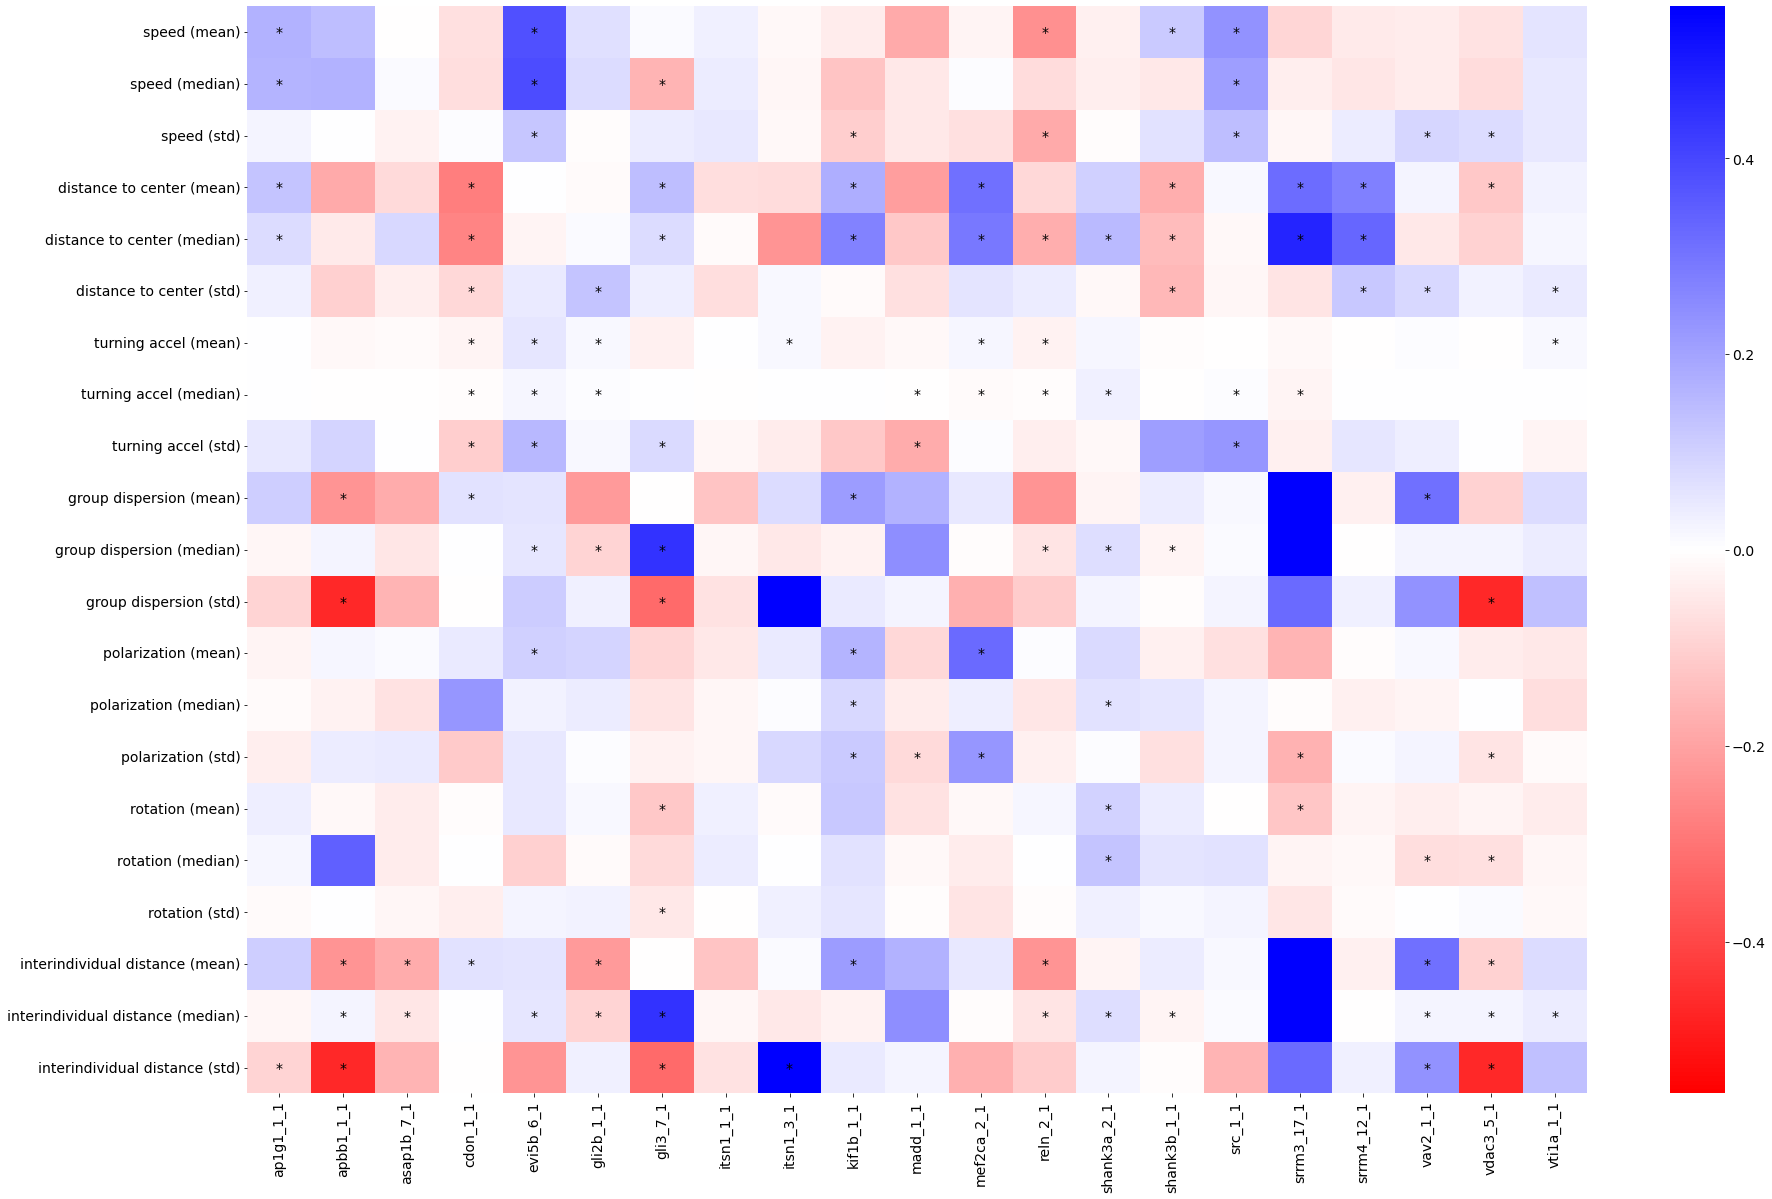

In [35]:
fig, ax = plt.subplots(1,1, figsize=(30, 20))
lim = np.max(np.abs(heatmap_vals[[c for c in heatmap_vals.columns if 'srrm3_17' not in c]].values))
sns.heatmap(
    data=heatmap_vals, 
    cmap='bwr_r', 
    annot=heatmap_stars, 
    fmt="", 
    annot_kws={"c":'k', "fontsize":14},
    vmin=-lim,
    vmax=lim,
)

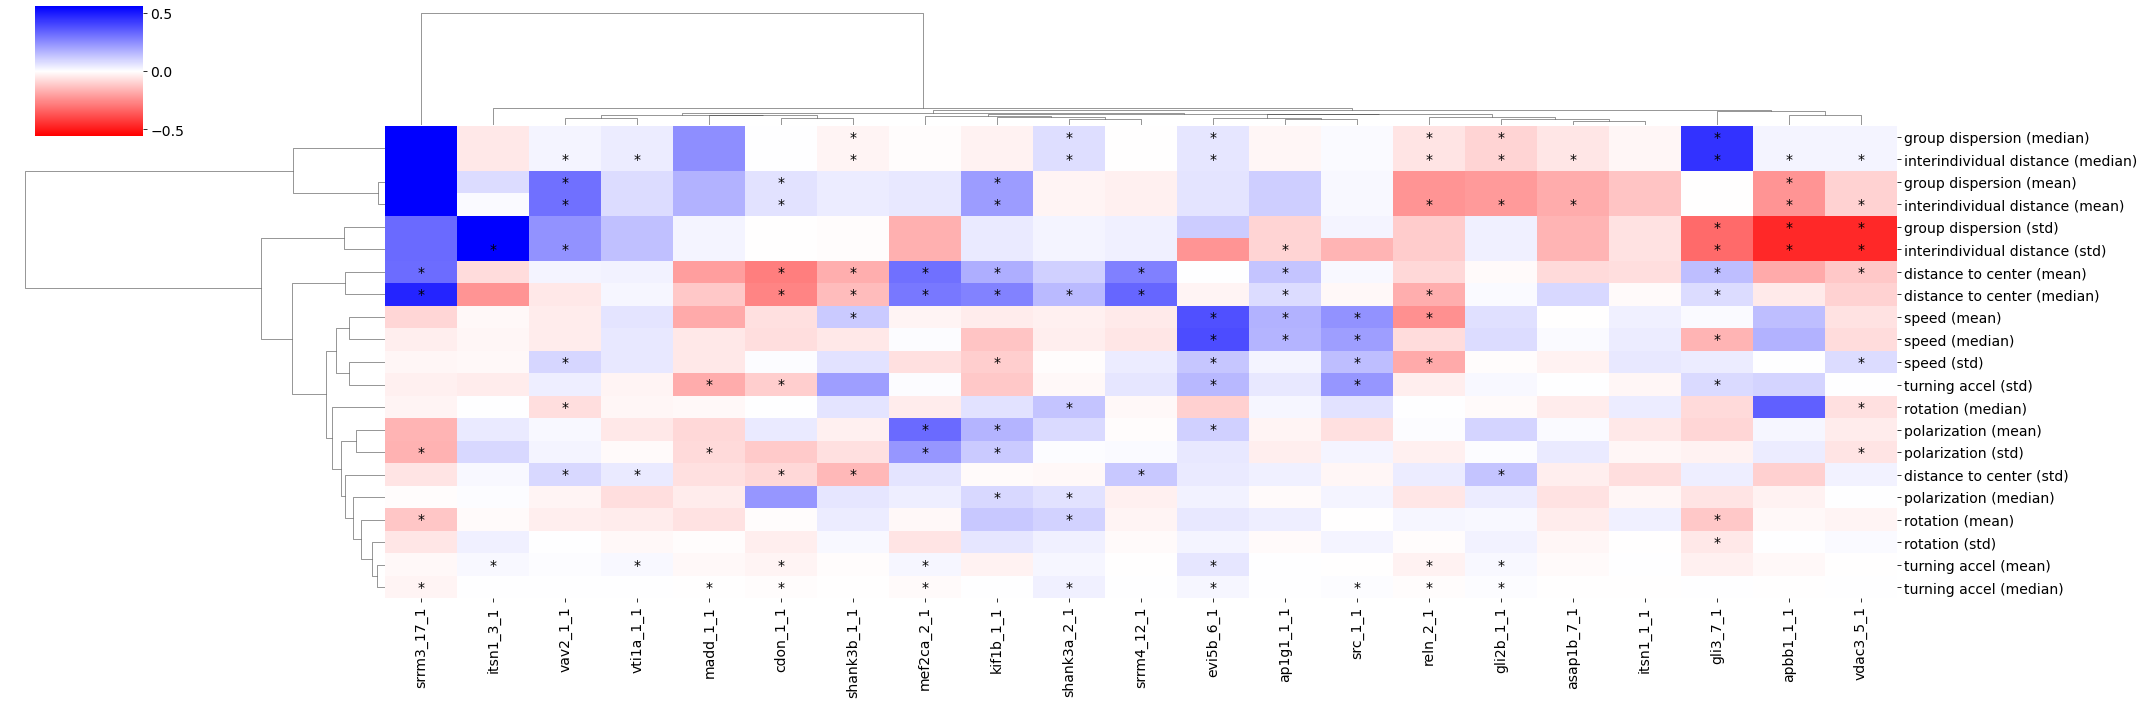

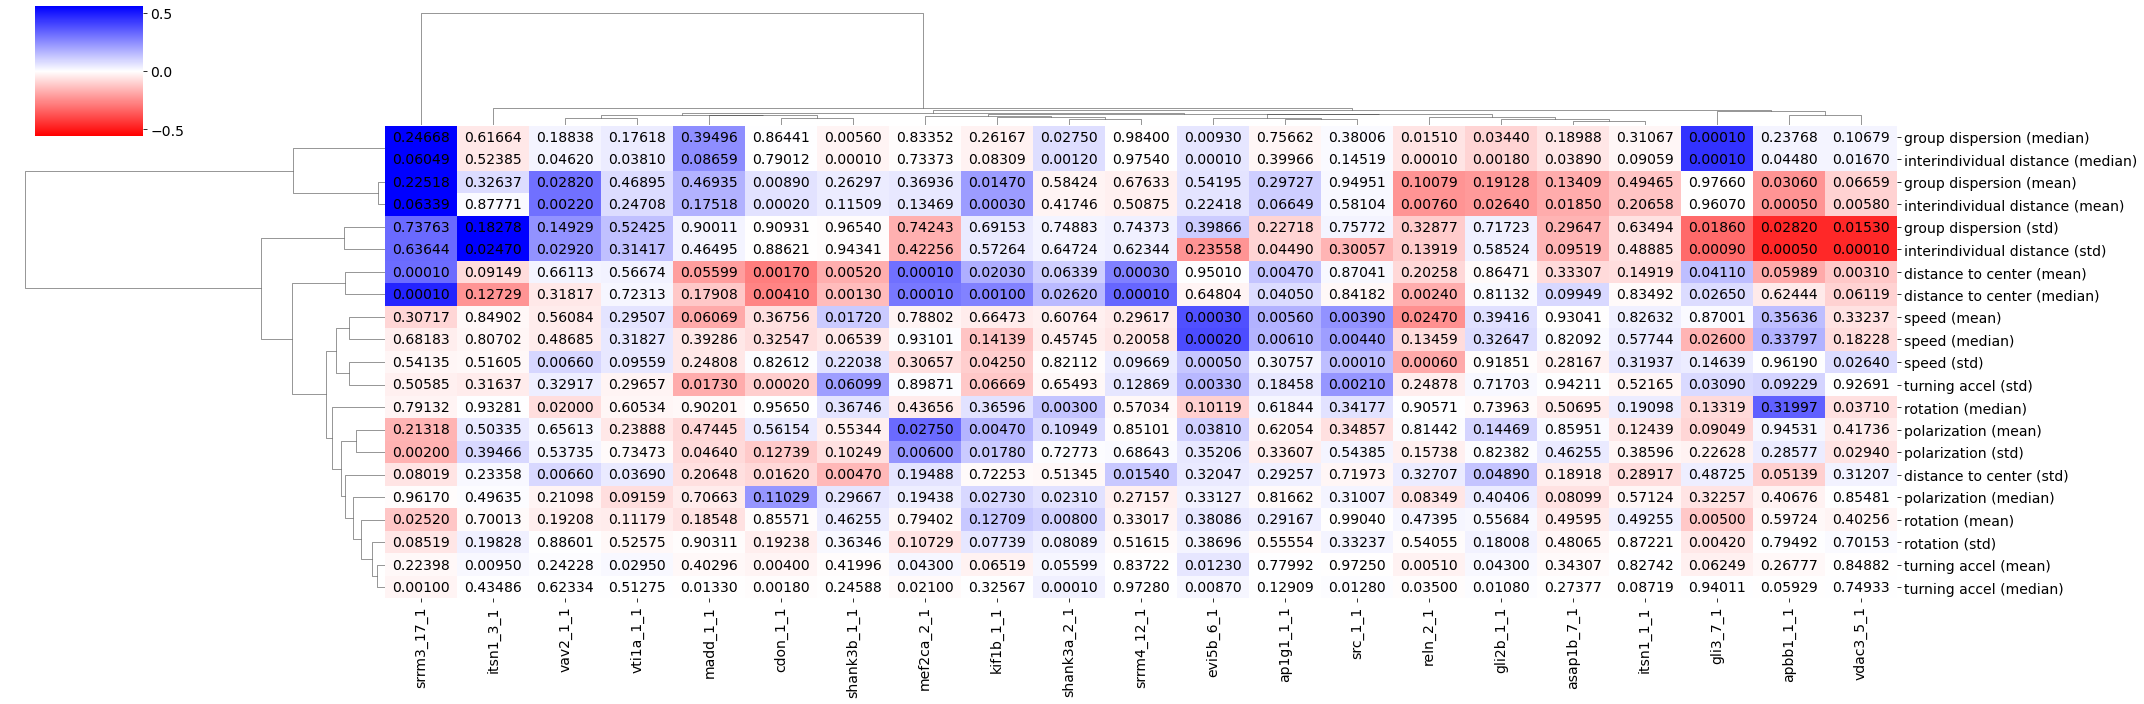

In [36]:
formats = {
    "stars": {"suffix": "", "annot": heatmap_stars, "fmt": ""}, 
    "_pvals": {"suffix": "_pvals", "annot": heatmap_pvals, "fmt": ".5f"},
}
for name, info in formats.items():
    sns.clustermap(
        data=heatmap_vals, 
        cmap='bwr_r', 
        figsize=(30, 10), 
        annot=info["annot"], 
        fmt=info["fmt"], 
        annot_kws={"c":'k', "fontsize":14},
        col_cluster=True, 
        row_cluster=True,
        vmin=-lim, 
        vmax=lim,
    )
    fig = plt.gcf()
    fig.savefig(os.path.join(conf.GENERATED_FIGURES_PATH, f"summary_{partition_col}_{DATE}_{STAT}", f"heatmap{info['suffix']}.pdf"))
    fig.savefig(os.path.join(conf.GENERATED_FIGURES_PATH, f"summary_{partition_col}_{DATE}_{STAT}", f"heatmap{info['suffix']}.png"))